## Pomyslalem ze podziele sie paroma trudnosciami
Ponizej kod ktorego bedziemy uzywac {{1}}

In [38]:
import sys
sys.executable


'/usr/bin/python3.6'

In [39]:
import numpy as np, matplotlib.pyplot as plt, cv2 as cv, pandas as pd
from skimage.data import coins
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.morphology import label, closing, square
from skimage.measure import regionprops
from skimage.color import lab2rgb
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.misc as misc
import skimage.filters
import scipy
from sklearn.decomposition import PCA
import copy
from tqdm import tqdm
from scipy import ndimage
from skimage import restoration
from skimage import img_as_float
#%matplotlib inline

In [97]:
def show(self, cmap=None):
        cmap = cmap or plt.cm.gray
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        ax.imshow(self, cmap=cmap)
        ax.set_axis_off()
        #plt.show()
        return fig
    
class Image(dict):
    
    def threshold(self, t=25):
        mask = self.array < t
        min_img.array[mask] = 0
        return
    
    def show(self, cmap=None):
        cmap = cmap or plt.cm.gray
        fig = plt.figure()
        fig.subplots_adjust(hspace=0.4, wspace=0.4)
        ax = fig.add_subplot(1, 1, 1)
        #fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        x = ax.imshow(self.array, cmap=cmap)
        ax.set_axis_off()
        #plt.show()
        plt.ioff()
        plt.close()
        return fig
    
    def denoise(self):
        im = copy.deepcopy(self)
        im.array = img_as_float(im.array)
        im.array = restoration.denoise_nl_means(im.array, h=0.05)
        return im

    def preprocess(self):
        #self.array = cv.cvtColor(self.array,cv.COLOR_BGR2GRAY)
        cv.imwrite('img001_otsu.png',self.array)
        t = threshold_otsu(self.array)
        self.img_bin = clear_border(closing(self.array > t, square(5)))
        self.labels = label(self.img_bin)
        #show(labels, cmap=plt.cm.rainbow)
        self.regions = regionprops(self.labels)
        #cv.imwrite('93_sobel_x_bin.png',img_bin)
        print(t)
        return self.img_bin, self.labels, self.regions

    def get_areas(self):
        rows = []
        n=0
        for region in self.regions:
            n += 1
            row = [n, region['BoundingBox'], region['Area']]
            rows.append(row)
        df = pd.DataFrame(rows,columns=['no','bounding_box','area'])
        df.sort_values('area',ascending=False,inplace=True)
        return df
    
    def get_border(self, left=4, right=10):
        df_15, df_4 = [pd.DataFrame(np.argwhere(self.labels==i), columns=['y','x'
                    ]) for i in [right, left]]
        df_15_left = df_15.groupby('y').min().reset_index()
        df_4_right = df_4.groupby('y').max().reset_index()
        df_concat = pd.concat([df_4_right, df_15_left])
        df_middle = df_concat.groupby('y').mean().reset_index()
        df_middle['x'] = df_middle['x'].apply(round)
        df_middle.to_csv('df_middle.csv',index=False)
        df_middle.plot(kind='scatter', x='x',y='y',xlim=(0,200))
        return df_middle    

    def plot_PCA(img):
        y, x = np.nonzero(self.array)
        x = x - np.mean(x)
        y = y - np.mean(y)
        coords = np.vstack([x, y])
        cov = np.cov(coords)
        evals, evecs = np.linalg.eig(cov)
        sort_indices = np.argsort(evals)[::-1]
        x_v1, y_v1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
        x_v2, y_v2 = evecs[:, sort_indices[1]]
        scale = -20
        plt.plot([0, x_v1*scale*2],
                 [0, y_v1*scale*2], color='red')
        plt.plot([0, x_v2*scale],
                 [0, y_v2*scale], color='blue')
        #plt.plot(x, y, 'k.')
        plt.axis('equal')
        plt.gca().invert_yaxis()  # Match the image system with origin at top left
        plt.show()
        fig, ax = plt.subplots()
        ax.imshow(img)
        ax.plot([0, x_v1*scale*2],
         [0, y_v1*scale*2], color='red')
        ax.plot([0, x_v2*scale],
                [0, y_v2*scale], color='blue')
        #ax.plot(x, x, '--', linewidth=5, color='firebrick')
        return

    def get_arr_3D(self, threshold=25):
        if len(self.array.shape) == 3:
            self.array = self.array[:,:,0]
        y_size, x_size = self.array.shape
        self.arr_3D = np.zeros([y_size,x_size,int(self.array.max())+1])
        mask = self.array < threshold
        self.array[mask] = 0
        for i in range(y_size):
            for j in range(x_size):
                z = int(self.array[i,j])
                if z > 0:
                    self.arr_3D[i,j,z] = 1
        return self.arr_3D    

    def plot_PCA_3D(self):
        if 'arr_3D' not in self.__dict__.keys():
            self.get_arr_3D()
        y, x, z, intensity = np.nonzero(self.arr_3D)
        x_m, y_m, z_m, i_m = [np.mean(i) for i in [x,y,z,intensity]]
        x = x - np.mean(x)
        y = y - np.mean(y)
        z = z - np.mean(z)
        coords = np.vstack([x, y, z])
        cov = np.cov(coords)
        evals, evecs = np.linalg.eig(cov)
        sort_indices = np.argsort(evals)[::-1]
        x_v1, y_v1, z_v1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
        x_v2, y_v2, z_v1 = evecs[:, sort_indices[1]]
        x_v3, y_v3, z_v3 = evecs[:, sort_indices[2]]

        # ktory ma wieksze wartosci w x,y
        #sprawdzic czy nie idzie za bardzo w z!
        scale = 10
        #plt.plot([x_m, x_m + x_v1*scale*2],
        #     [y_m,y_m + y_v1*scale*2], color='red')
        #plt.plot([x_m, x_m + x_v2*scale],
        #     [y_m, y_m + y_v2*scale], color='blue')
        #plt.plot(x, y, 'k.')
        #plt.axis('equal')
        #plt.gca().invert_yaxis()  # Match the image system with origin at top left
        #plt.show()
        fig, ax = plt.subplots(1,1)
        #x = range(300)
        ax.imshow(self.array)
        ax.plot([x_m - x_v1*scale, x_m +x_v1*scale], [y_m - y_v1*scale, y_m +y_v1*scale*2], color='red')
        ax.plot([x_m - x_v2*scale, x_m + x_v2*scale], [y_m - y_v2*scale, y_m +y_v2*scale], color='blue')
        ax.plot([x_m - x_v3*scale, x_m + x_v3*scale], [y_m - y_v3*scale, y_m +y_v3*scale], color='green')
        #ax.plot([x_m +0, x_m +x_v1*scale*2], [y_m +0, y_m +y_v1*scale*2], color='red')
        #ax.plot(x, x, '--', linewidth=5, color='firebrick')
        self.vec = [x_v2, y_v2]
        self.vecs = evecs[:, sort_indices[:2]]
        self.a = y_v2/x_v2
        self.a_p = x_v2/y_v2
        plt.ioff()
        plt.close()
        return fig

    def plot_PCAs_3D(self):
        figs = []
        self.a_ps = []
        self.vecss = []
        for slice_i in self.slices:
            figs.append(slice_i.plot_PCA_3D())
            self.a_ps.append(slice_i.a_p)
            self.vecss.append(slice_i.vecs)
        return figs
    
    def plot_3D(self):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        y,x,z = np.nonzero(self.arr_3D)
        #z = (np.ones(np.size(u)),
        ax.scatter(x, y, z,marker='^',c=z, cmap=plt.cm.autumn)
        #ax.plot_surface(x, y, z, color='b')
        ax.set_xlabel('x')
        return fig

    def calc_dev(self, epsilon=0):
        mask = self.array < 10
        self.array[mask] = 0
        y, x = np.nonzero(self.array)
        x_m, y_m, z_m = [np.mean(i) for i in [x,y,z]]
        #epsilon = 0
        #arr_3D y_m
        y_window = 5
        x_pos = int(round(x_m)) + epsilon
        y_m_i = int(round(y_m))
        left_points = self.array[y_m_i-y_window:y_m_i+y_window, 0:x_pos]
        y,x = np.nonzero(left_points)
        sum_diff = 0.0
        for i in range(y.shape[0]):
            diff = self.array[y[i],x[i]] - self.array[y[i], x_pos + x_pos - x[i]] 
            sum_diff += diff**2
        sum_diff = (sum_diff)**(0.5)/y.shape[0]
        return sum_diff
    
    def get_middle_slice(self, dist = 5, weighted=False):
        ###
        #tu jest confusion bo niech to bierze tylko srodkowy pasek
        ###
        cls = self.__class__
        mid_slice = cls()
        mid_slice.array = copy.deepcopy(self.array)
        mid_slice.a = self.a
        h, w = mid_slice.array.shape[:2]
        x1 = np.arange(w) 
        mask = np.zeros(mid_slice.array.shape, dtype=np.uint8)
        y, x = np.nonzero(mid_slice.array)
        y_m, x_m = self.get_weighted_mean()
        ang_rad = np.arctan2(self.vec[0],self.vec[1])
        ang_deg = ang_rad*360/(2*np.pi)
        y_dist = dist /np.cos(ang_rad)
        self.b_p_m = y_m - (x_m/-self.a)
        self.b_m = y_m - (x_m*self.a)
        mid_slice.b_m = self.b_m

        b_up = self.b_p_m - y_dist
        b_down = self.b_p_m + y_dist
        
        polynomial1 = lambda x: (x/-self.a) + b_up
        polynomial2 = lambda x: (x/-self.a) + b_down
        y1 = polynomial1(x1)
        y2 = polynomial2(x1)
        points1 = np.array([[[xi, yi]] for xi, yi in zip(x1, y1) if (0<=xi<w and 0<=yi<h)]
                  ).astype(np.int32)
        points2 = np.array([[[xi, yi]] for xi, yi in zip(x1, y2) if (0<=xi<w and 0<=yi<h)]
                  ).astype(np.int32)
        points = np.concatenate((points1, np.flip(points2, 0)))
        polynomialgon = copy.deepcopy(mid_slice.array)
        polynomialgon.fill(0)
        mask = cv.fillPoly(polynomialgon, [points], color=[255,255,255])
        mid_slice.array = cv.bitwise_and(mid_slice.array,mask)           
        '''

            roi_corners = cv2.rectangle(self.array,(b_up, x1),
                                        (x/self.a + b_down, x2),(255))
        else:
            x_dist = dist /np.sin(ang_rad)

            roi_corners = cv2.rectangle(self.array,(0, -b_down*self.a),(self.array.shape[0]-1,
                        self.array.shape[1]-1),(255))
        '''
        return mid_slice

    def calc_dev_slice(self, epsilon =0):
        b = self.b_m + epsilon
        a = self.a
        #mask = self.array < 100
        #self.array[mask] = 0
        left_points = copy.deepcopy(self.array)
        for y in range(self.array.shape[0]):
            for x in range(self.array.shape[1]):
                if x > ((y - b)/self.a):
                    left_points[y,x] = 0
        y, x = np.nonzero(left_points)
        sum_diff = 0.0
        oob = 0
        for i in range(y.shape[0]):
            x1 = x[i]
            y1 = y[i]
            #y = a*x + b
            d = (x1 + (y1 - b)*a)/(1 + a**2.0)
            x2 = int(round(2*d - x1))
            y2 = int(round(2*d*a - y1 + 2*b))
            #print(x2,y2)
            try:
                sum_diff += (self.array[y1,x1] - self.array[y2, x2])**2
            except IndexError:
                #jesli punkt nie istnieje to przyjmujemy intensywnosc zero bierzemy zero
                sum_diff += (self.array[y1,x1])**2
                #oob +=1
        div = y.shape[0]# - oob
        if div==0:
            sum_diff = 10000.0
        else:
            sum_diff = (sum_diff)**(0.5)/div#(div*np.log(div))
        #fig, ax = plt.subplots(1,1)
        #ax.imshow(self.array)
        #ax.plot(xs, ys, color='red')
        return sum_diff

    def calc_devs_slice(self, epsilon_range=[-20,20]):
        y, x = np.nonzero(self.array)
        devs = []
        epsilons = range(epsilon_range[0],epsilon_range[1])
        for eps in epsilons:
            eps_real = eps * self.a
            devs.append(self.calc_dev_slice(epsilon=eps))
        epsval = epsilons[np.array(devs).argmin()]
        ys = np.linspace(np.min(y),np.max(y))
        xs = [((y_i - self.b_m -epsval)/self.a) for y_i in ys]
        fig, ax = plt.subplots(1,1)
        ax.imshow(self.array)
        ax.plot(xs, ys, color='red')        
        return np.array(devs)
        

    
    @classmethod
    def get(cls, path):
        i = cls()
        i.array = cv.imread(path)
        return i

    @classmethod
    def from_array(cls, array):
        i = cls()
        i.array = array
        return i
    
    def rotate(self,angle):
        self.array = scipy.ndimage.rotate(self.array,angle)
        return
    
    def get_sym_curve():
        return
    
    def get_y_slices(self, window=50, step=1):
        self.slices = []
        cls = self.__class__
        for y_min in tqdm(range(0, self.array.shape[0] - window, 1)):
            slice_i = cls()
            slice_i.array = copy.deepcopy(self.array)
            slice_i.array = slice_i.array[y_min:y_min + window,:]
            self.slices.append(slice_i)
        return self.slices
    
    def convolve(self, k):
        i = copy.deepcopy(self)
        #i.array = cv.cvtColor(i.array,cv.COLOR_BGR2GRAY)
        i.array = ndimage.convolve(i.array, k, mode='constant', cval=0.0)
        return i
    
    def sobel_x(self):
        i = copy.deepcopy(self)
        i.array = cv.Sobel(i.array[:,:,0],cv.CV_64F,1,0,ksize=5)
        return i
    
    def get_x_slopes(self):
        return
    
    def get_x_slopes_integrated(self):
        return
    
    def crop(self, range_y, range_x):
        up, down = range_y
        left, right = range_x
        self.array = self.array[up:down, left:right]
        return

    def get_weighted_mean(self, bground = 25.0):
        y,x, z = np.nonzero(self.arr_3D)
        sum_i_x = 0.0
        sum_i_y = 0.0
        z = z - bground
        for i in range(y.shape[0]):
            sum_i_x += x[i] * z[i]
            sum_i_y += y[i] * z[i]
        mean_x = sum_i_x/np.sum(z)
        mean_y = sum_i_y/np.sum(z)
        self.weighted_mean = [mean_y, mean_x]
        return self.weighted_mean


class Voxel(Image):
    def plot_PCA3D():
        return

    @classmethod
    def from_paths():
        return
    
    @classmethod
    def from_array(cls, array):
        i = cls()
        i.array = array
        return i
    
    def get_arr_3D(self, threshold=25):
        if len(self.array.shape) == 4:
            self.array = self.array[:,:,:,0]
        z_size, y_size, x_size = self.array.shape
        self.arr_3D = np.zeros([y_size,x_size,z_size, int(self.array.max())+1])
        mask = self.array < threshold
        self.array[mask] = 0
        for i in range(y_size):
            for j in range(x_size):
                for k in range(z_size):
                    intensity = int(self.array[k, i, j])
                    if intensity > 0:
                        self.arr_3D[i,j,k,intensity] = 1
        return self.arr_3D

    def plot_3D(self):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        y,x,z,i, = np.nonzero(self.arr_3D)
        #z = (np.ones(np.size(u)),
        ax.scatter(x, y, z,marker='^',c=i, cmap=plt.cm.autumn)
        #ax.plot_surface(x, y, z, color='b')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        ax.plot_surface
        return fig

    def plot_PCA_3D(self):
        if 'arr_3D' not in self.__dict__.keys():
            self.get_arr_3D()
        y, x, z, intensity = np.nonzero(self.arr_3D)
        x_m, y_m, z_m, i_m = [np.mean(i) for i in [x,y,z,intensity]]
        x = x - np.mean(x)
        y = y - np.mean(y)
        z = z - np.mean(z)
        intensity = intensity - np.mean(intensity)
        coords = np.vstack([x, y, z, intensity])
        cov = np.cov(coords)
        evals, evecs = np.linalg.eig(cov)
        sort_indices = np.argsort(evals)[::-1]
        x_v1, y_v1, z_v1, i_v1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
        x_v2, y_v2, z_v2, i_v2 = evecs[:, sort_indices[1]]
        x_v3, y_v3, z_v3, i_v3 = evecs[:, sort_indices[2]]
        x_v4, y_v4, z_v4, i_v4 = evecs[:, sort_indices[3]]

        # ktory ma wieksze wartosci w x,y
        #sprawdzic czy nie idzie za bardzo w z!
        scale = 10
        #plt.plot([x_m, x_m + x_v1*scale*2],
        #     [y_m,y_m + y_v1*scale*2], color='red')
        #plt.plot([x_m, x_m + x_v2*scale],
        #     [y_m, y_m + y_v2*scale], color='blue')
        #plt.plot(x, y, 'k.')
        #plt.axis('equal')
        #plt.gca().invert_yaxis()  # Match the image system with origin at top left
        #plt.show()
        fig, ax = plt.subplots(1,1)
        #x = range(300)
        ax.imshow(self.array[25,:,:])
        ax.plot([x_m - x_v1*scale, x_m +x_v1*scale], [y_m - y_v1*scale, y_m +y_v1*scale*2], color='red')
        ax.plot([x_m - x_v2*scale, x_m + x_v2*scale], [y_m - y_v2*scale, y_m +y_v2*scale], color='blue')
        ax.plot([x_m - x_v3*scale, x_m + x_v3*scale], [y_m - y_v3*scale, y_m +y_v3*scale], color='green')
        ax.plot([x_m - x_v4*scale, x_m + x_v4*scale], [y_m - y_v4*scale, y_m +y_v4*scale], color='yellow')
        #ax.plot([x_m +0, x_m +x_v1*scale*2], [y_m +0, y_m +y_v1*scale*2], color='red')
        #ax.plot(x, x, '--', linewidth=5, color='firebrick')
        self.vec = [x_v2, y_v2]
        self.vecs = evecs[:, sort_indices[:2]]
        self.a = y_v2/x_v2
        self.a_p = x_v2/y_v2
        plt.ioff()
        plt.close()
        return fig

In [41]:
img = Image.from_array(cv.imread('0093.png'))#[:,:,0])
fig = img.show()
im_denoised = img.denoise()
fig_denoised = im_denoised.show()
img_denoised_sobel_x = im_denoised.sobel_x()
for i in img, im_denoised:
    i.rotate(7)
    i.sobelled_x = i.sobel_x()
    i.fig_sobelled_x = i.sobelled_x.show()
    i.labels = i.sobelled_x.preprocess()[1]
    i.seg_df = i.sobelled_x.get_areas()

/usr/local/lib/python3.6/dist-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


1248.423828125
5.043395285422944


### Wybór skrawka
Do analizy wybrałem skrawek o numerze 93, bo półkule są na nim dobrze oddzielone.
Spróbujmy 'oczyścić' trochę obraz przez nl_means denoising.


read image | denoised image
- | - 
{{fig}} | {{fig_denoised}}

Jak widzimy przez takie 'wygładzenie' tracimy sporo informacji. Jednak półkule
wydają się teraz bardziej jednolite i wydaje się, że łatwiejsze do ogólnej segmentacji.


### Wykrywanie krawędzi pomiędzy półkulami
Okazuje się, że z wykryciem krawędzi dobrze radzi sobie filtr Sobela, szczególnie
w kierunku x. Lepsze rezultaty otrzymujemy dla obrazu po denoisingu

image after sobel x| denoised image after sobel x
- | - 
{{img.fig_sobelled_x}} | {{im_denoised.fig_sobelled_x}}

### Przyjrzyjmy się wykrytym krawędziom
raw image | denoised image 
- | - 
{{fig1 = show(img.labels, cmap=plt.cm.viridis)}} | {{fig2 = show(im_denoised.labels, cmap=plt.cm.viridis)}}

Trochę lepsze wyniki są dla surowego obrazu.

### Przyjrzyjmy się wielkościom i lokalizacjom największych wykrytych krawędzi
raw image | denoised image 
- | - 
{{img.seg_df.head(5)}} | {{im_denoised.seg_df.head(5)}}



In [42]:
for i in [3,6,5]:
    mask = img.labels == i
    img.labels[mask] = 10

### Przyjrzyjmy się wielkościom i lokalizacjom największych wykrytych krawędzi

polaczone regiony |  granica polkul
- | - 
{{x =show(img.labels, cmap=plt.cm.viridis)}} | {{border = img.get_border(left=4, right=10)}}

wyznacza nam to ROI na [60:230],[0:50]

### ponizej mozna sie pobawic thresholdem w obrazku po przejsciu Sobela

In [43]:
from ipywidgets import widgets

@widgets.interact(t=(50, 240))
def threshold(t): 
    show(img.sobelled_x.array > t)

interactive(children=(IntSlider(value=145, description='t', max=240, min=50), Output()), _dom_classes=('widget…

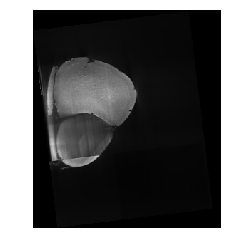

In [44]:
img.show()

In [45]:
img.crop([60,230],[0,50])
img.show()
#cv.imwrite('roi.png',roi)

slices = img.get_y_slices(window=50, step=1)
figs = img.plot_PCAs_3D()

100%|██████████| 120/120 [00:00<00:00, 21283.68it/s]


### Poszedłem po rozum do głowy i zwróciłem się do PCA

w 3 wymiarach x,y i intensywność jako z

1 |  2 
- | - 
{{figs[0]}} | {{figs[20]}} 
{{figs[40]}} | {{figs[-1]}} 

In [46]:
df = pd.DataFrame(img.a_ps, columns = ['slope_vs_y'])

In [47]:
from scipy import integrate
#df.apply(lambda g: integrate.trapz(g['slope_vs_y'], x=g.Index))

vals = []
for i in range(0,df.shape[0]):
    min_df = df[:i]
    vals.append(integrate.trapz(min_df['slope_vs_y'], x=min_df.index))
df['integral'] = vals
df.reset_index(inplace=True)

In [48]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 1, 1)
#fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        #plt.show()
#x = range(300)
x = ax.imshow(img.array); ax.plot(df['integral'], df['index']+25, color='red'); ax.plot(df['slope_vs_y']*10, df['index']+25, color='blue');
ax.set_axis_off()
plt.ioff()
plt.close()


Wiec tak:
slope wzgledem y jest na niebiesko
całka z niego jest na czerwono

{{fig}}

tak wiec nie da sie uzyskać krzywej symetrii poprzez scałkowanie
slope'u względem y

myślę o tym, żeby jakoś w poszczególnych slice'ach dobierać,
jakoś znajdować parametr b, który maksymalizowałby symetrię
względem osi symetrii (z PCA)
### tak wygląda pierwszy slice gdy przedstawi się intensywność jako z:
{{x = img.slices[0].plot_3D()}}

### Dalsze kroki
Teraz możemy albo sprobowac lokalnie 'przesuwać' oś symetrii (zmieniając parametr b osi) albo spróbować PCA na voxelach (np. 50 x 50 x 50)

### Przeprowadzić optymalizację parametru b

dla kazdej wartości b w jakims zakresie (np. 0,50).
policzyc
dla kazdego punktu P(x,y,z) po lewej stronie osi takiego ze y > ax + b (dla a>=0)
                                    albo y < ax + b (dla a<0)

bierzemy punkt (symetryczny względem osi po jej prawej stronie):
P'(x',y',z') taki ze wektor vec(P,P') = 2*vecP(P do ax+b)

mierzymy diff_z (różnicę w intensywności) = (z'-z)**2

sumujemy diff_z

i robimy (diff_z)**(1/2)
i moze dzielimy to przez len(Ps) albo len(Ps**2).
albo mnozymy przez exp-(len(Ps)), nie wiem.
albo dzielimy przez ln(len(Ps))

Nasza
jesli P' nie istnieje, to bierzemy z'=0 (sprobujmy)
i minimalizujemy to (zobaczymy jakie wyniki to da)

potem (druga godzina) sprawdzimy jak to robi ten program symmetry (te votes i w ogole) (optymalizacja paramteru r dla stalej theta)

 17%|█▋        | 20/120 [00:11<01:05,  1.53it/s]/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
100%|██████████| 120/120 [01:02<00:00,  2.65it/s]


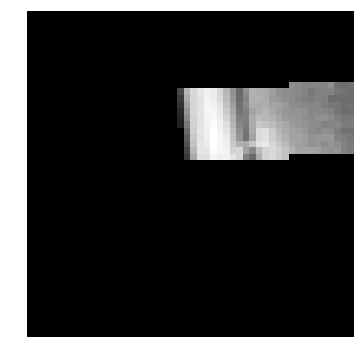

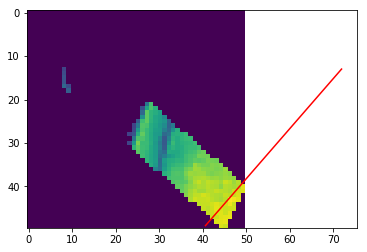

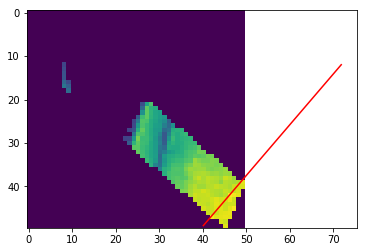

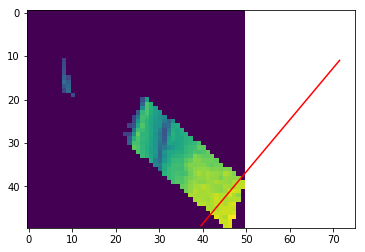

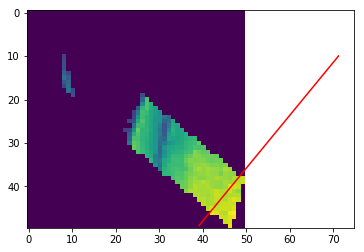

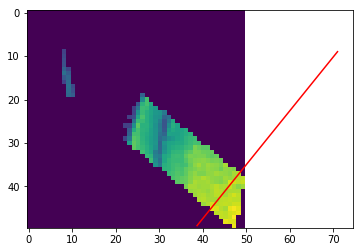

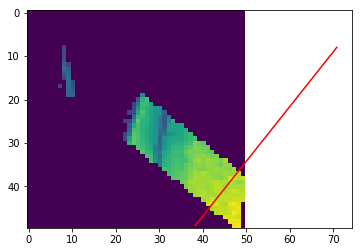

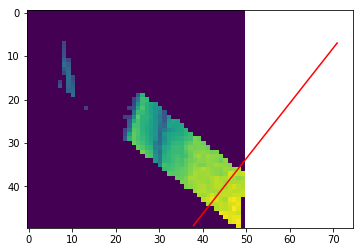

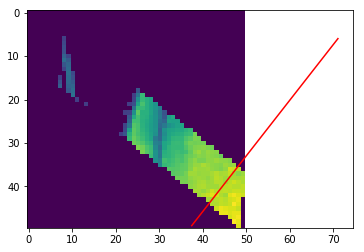

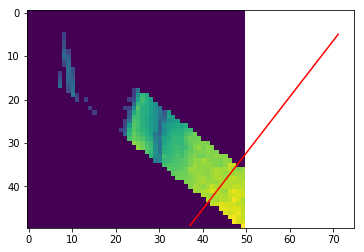

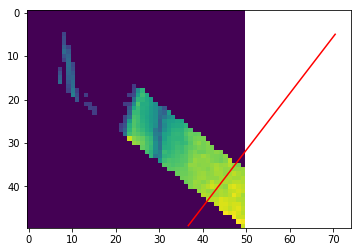

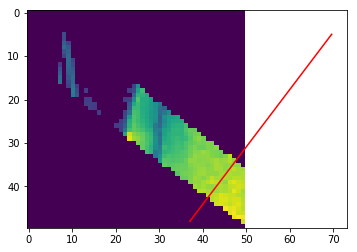

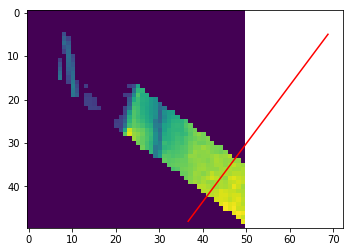

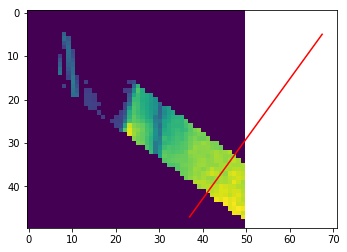

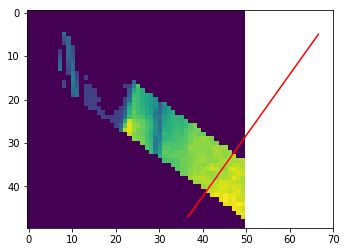

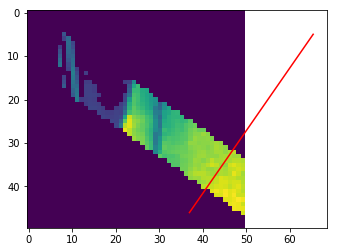

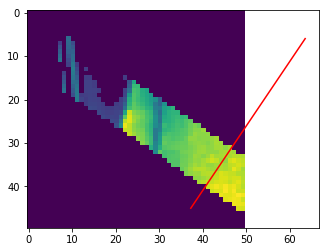

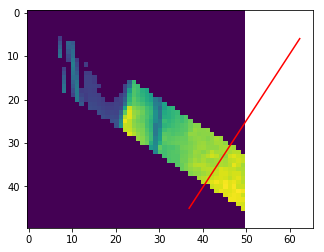

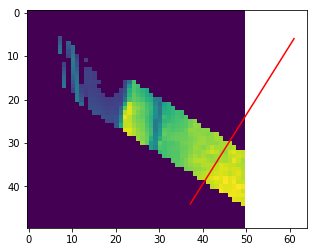

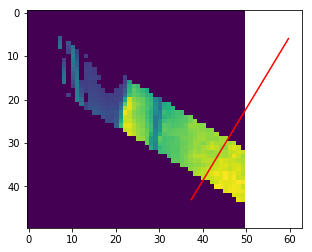

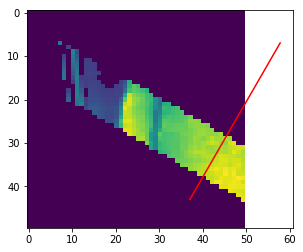

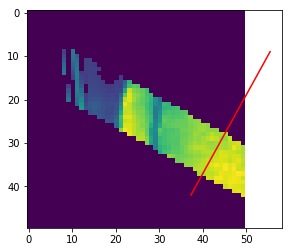

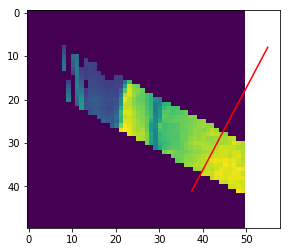

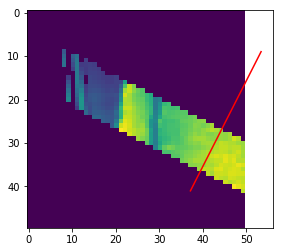

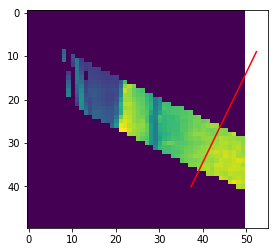

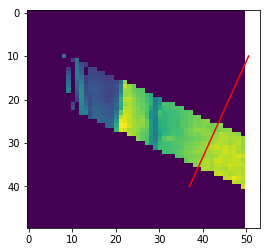

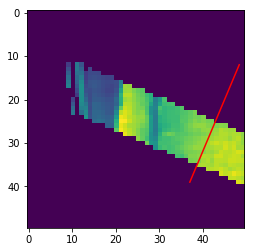

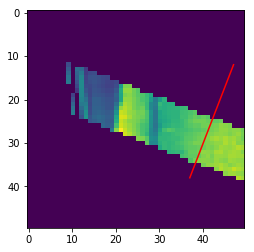

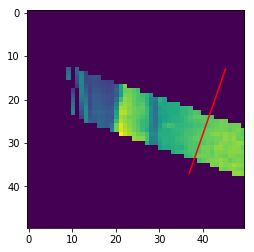

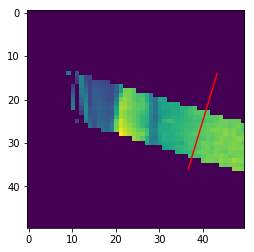

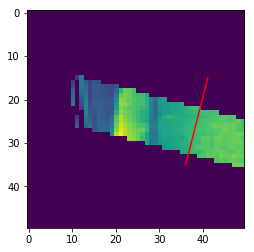

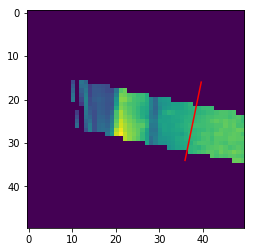

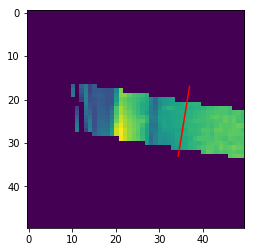

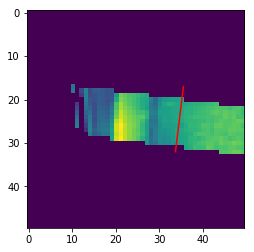

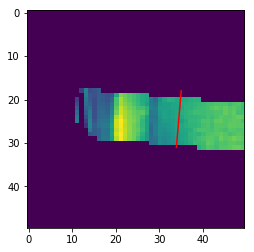

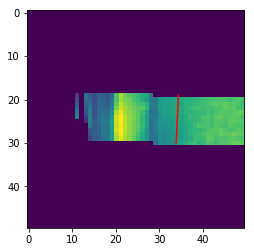

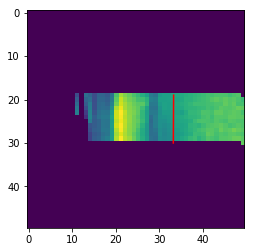

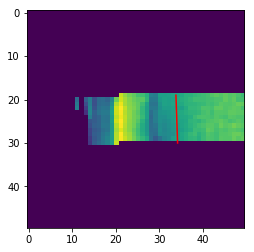

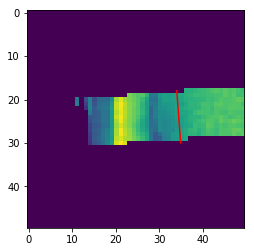

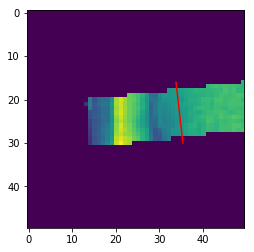

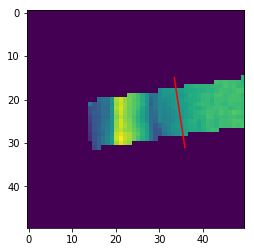

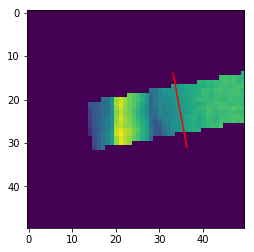

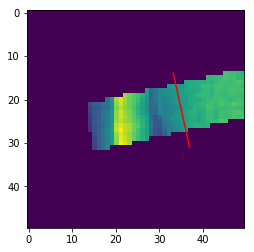

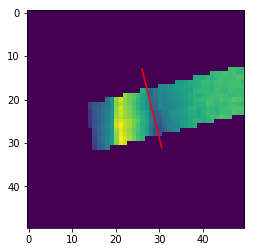

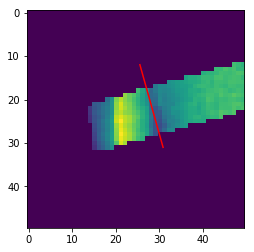

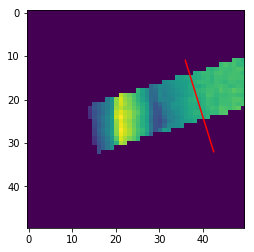

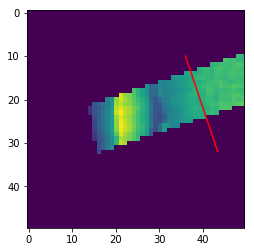

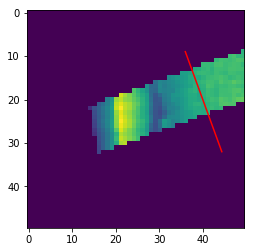

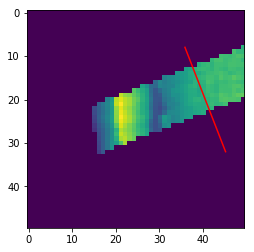

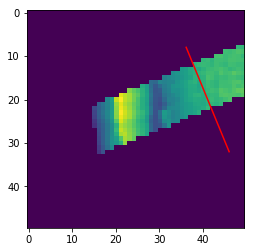

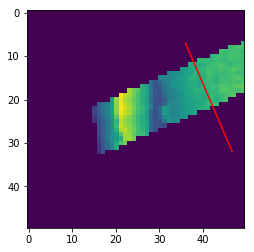

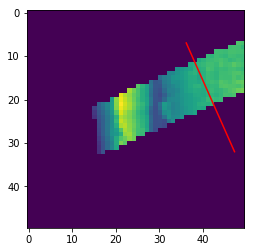

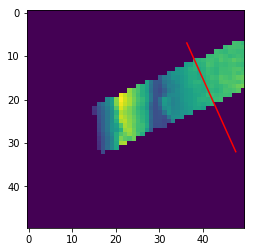

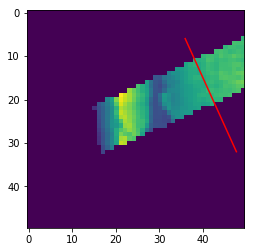

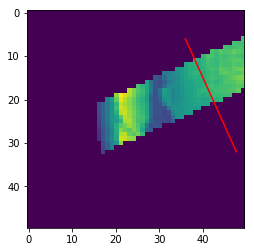

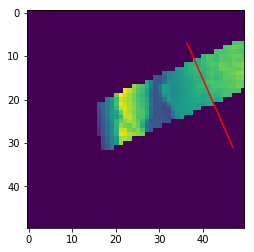

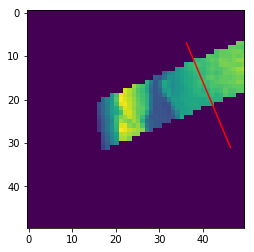

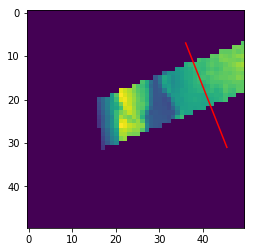

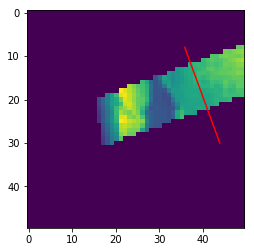

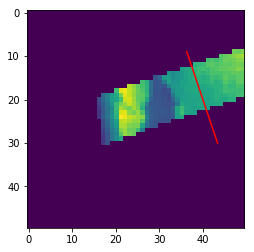

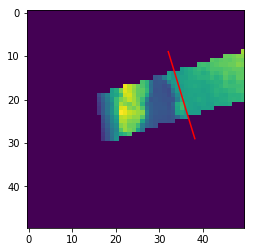

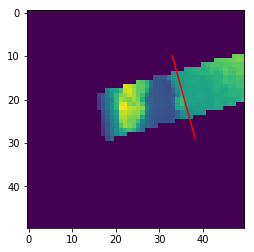

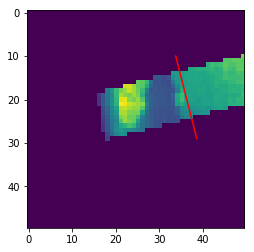

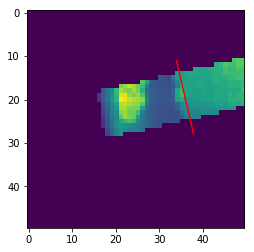

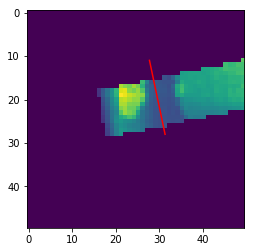

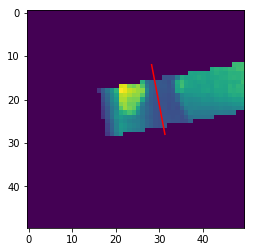

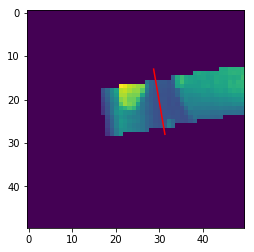

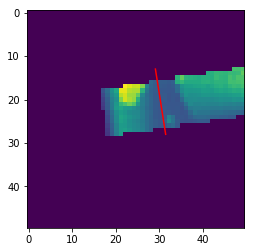

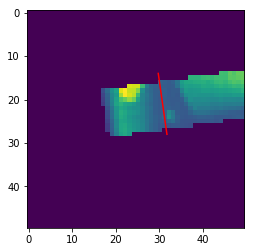

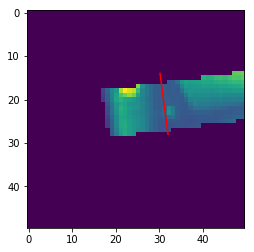

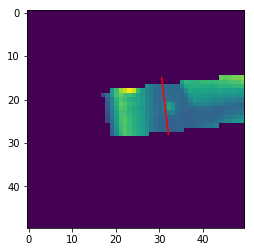

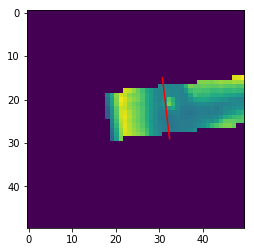

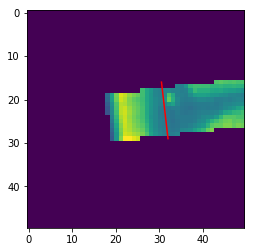

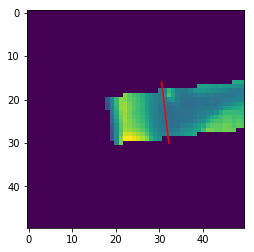

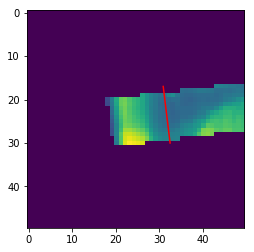

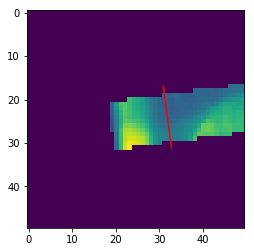

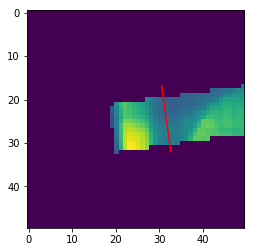

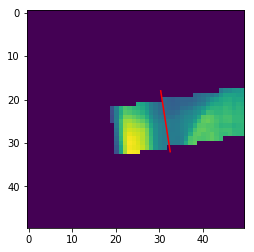

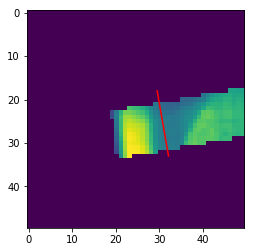

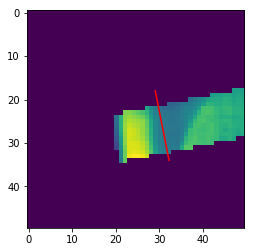

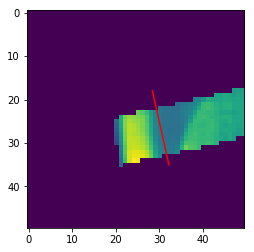

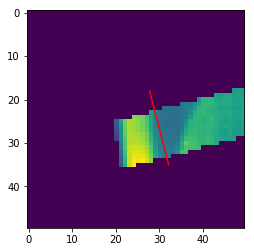

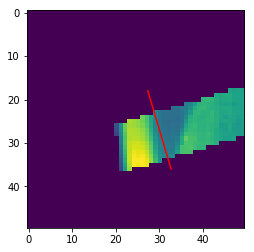

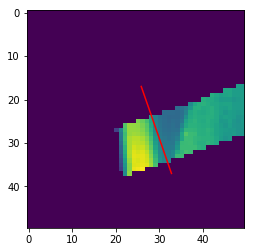

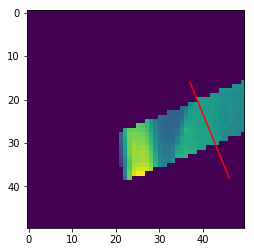

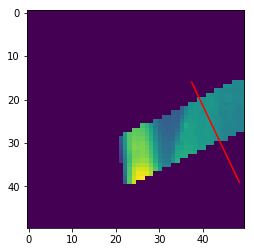

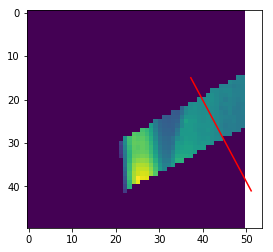

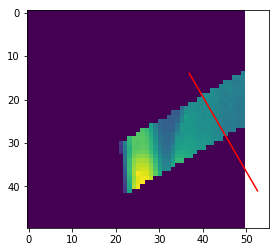

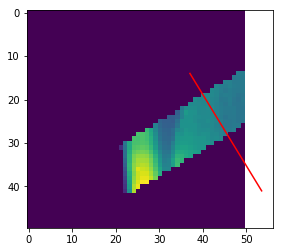

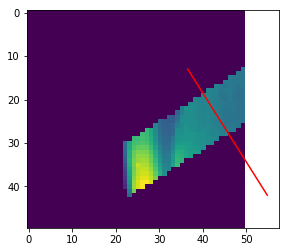

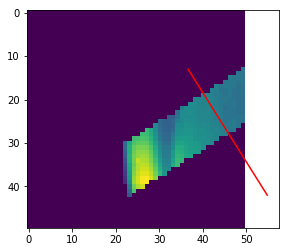

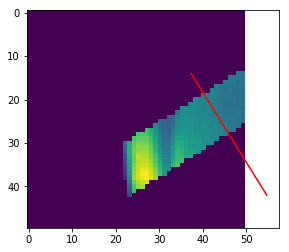

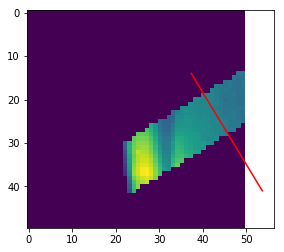

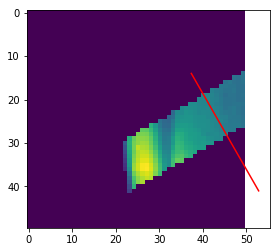

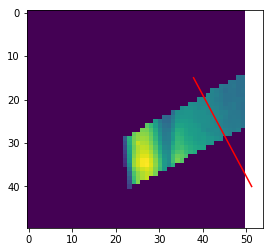

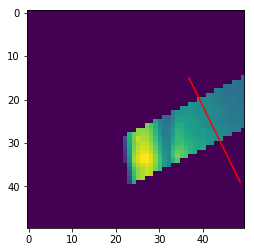

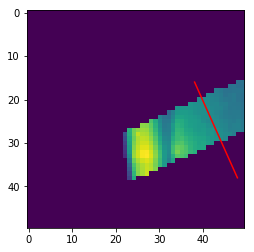

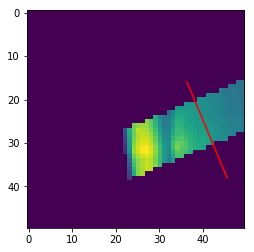

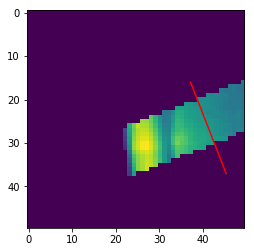

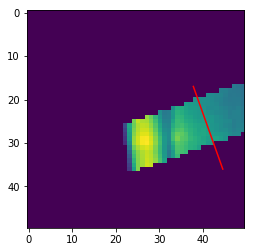

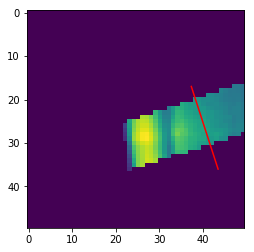

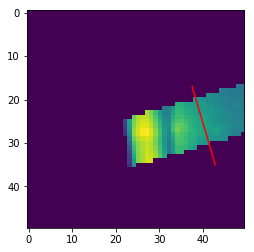

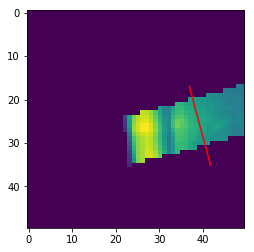

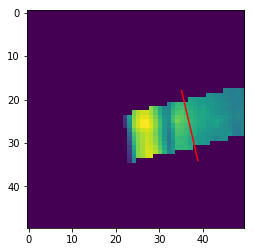

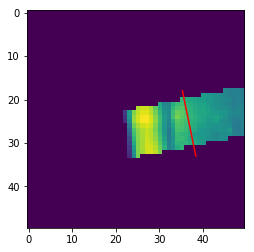

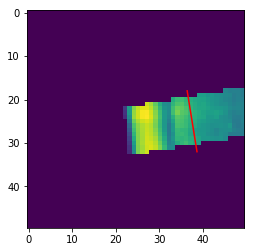

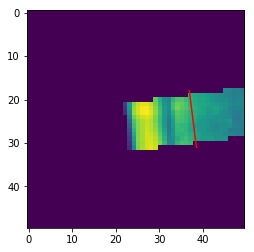

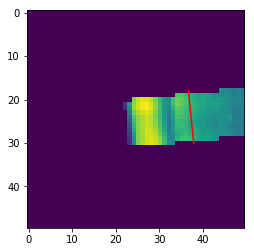

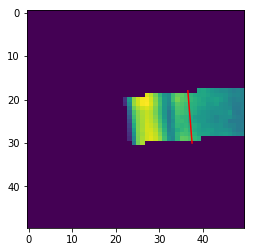

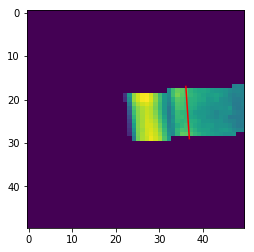

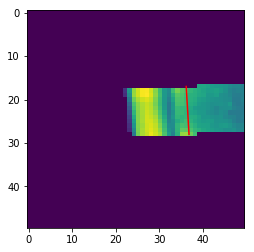

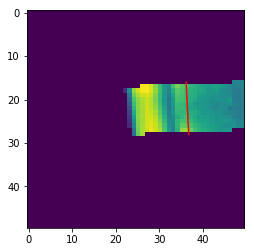

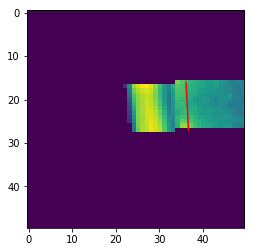

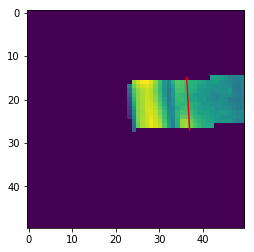

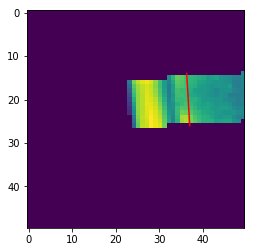

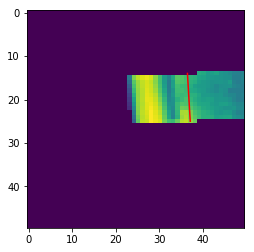

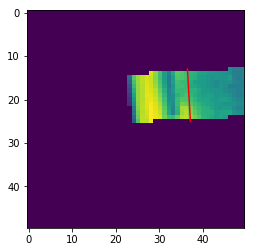

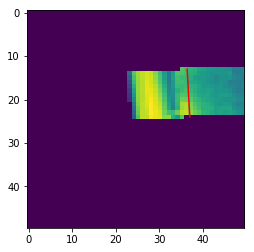

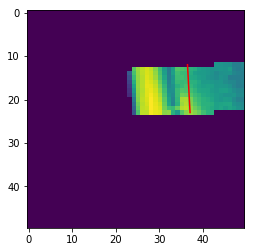

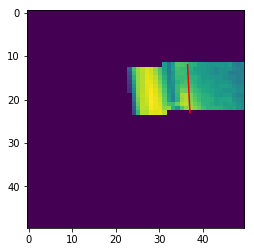

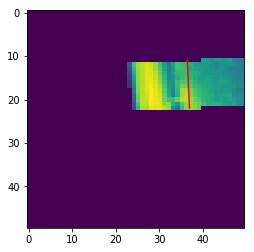

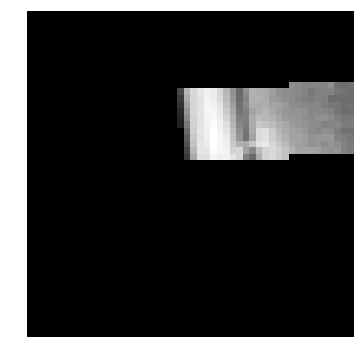

In [49]:
xs = []
figs = []
for slice_i in tqdm(img.slices):
    epsilons = []
    x = slice_i.get_middle_slice()
    xs.append(x)
    x.calc_devs_slice(epsilon_range=[-20,20])

show(x.array)
#e = x.calc_devs_slice(epsilon_range=[0,30])
#min_img.get_slice(y_m=y_m)
#epsilons.append(e)

### jak widzimy powyzej metoda sprawdza się różnie
Problemem jest na pewno różnica w oświetleniu różnych fragmentów próbki

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:264: RuntimeWarning: overflow encountered in ubyte_scalars


array([ 8.75050173,  9.02288778,  9.12533531,  9.33430144,  9.73594901,
        9.82940382,  9.91195418,  9.98193269, 10.05909748, 10.12188457,
       10.30883844, 10.35104482, 10.38969951, 10.72306376, 10.61431739,
       10.59514915, 10.80676865, 10.86864549, 11.06891591, 11.41432147,
       11.6190369 , 11.81333009, 11.90966885, 11.99664983, 12.233453  ,
       12.208616  , 12.12267513, 12.09921007, 12.0836435 , 12.06473211,
       11.89285641, 11.85870174, 11.89243475, 11.79194313, 11.68083616,
       11.55879347, 11.49215448, 11.346338  , 11.558635  , 11.78800218])

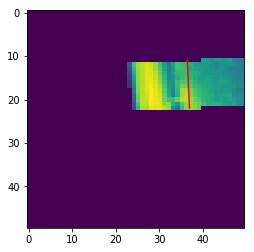

In [50]:
x.calc_devs_slice(epsilon_range=[-20,20])

In [51]:
#mozna tez gaussy
#wyplotowac funkcje deva

In [52]:
kernel_sharpening = np.array([[-1,-1,-1], 
                              [-1, 9,-1],
                              [-1,-1,-1]])

kernel_sharpening_x = np.array([[-1,0,-1], 
                              [-1, 9,-1],
                              [-1,0,-1]])

In [98]:
imgs = []
for i in range(93+25, 93-25, -1):
    #rint (i)
    img = Image.from_array(
        cv.imread('../../data/LSFM/000014_package/coronal/%04d.png' %i))
    imgs.append(img)

In [99]:
#show(imgs[0].array)

In [100]:
vstacked = np.array([i.array[60:50+60,:50,0] for i in imgs])

In [101]:
vstacked.shape

(50, 50, 50)

In [102]:
del imgs

In [103]:
#przydaloby sie reshapowac to

In [59]:
#ax = fig.gca(projection='3d')
#ax.voxels(vstacked[:,:,:,0], edgecolor='k')

#plt.show()

In [104]:
v = Voxel.from_array(vstacked)

In [105]:
v.get_arr_3D(threshold=100)

array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
    

In [95]:
del vstacked

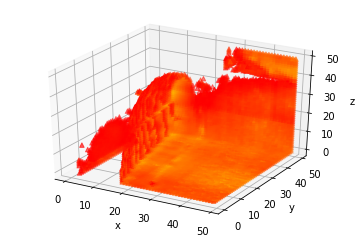

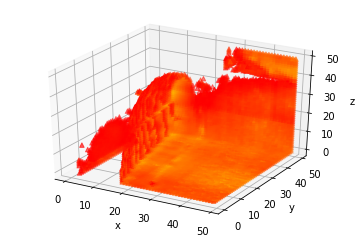

In [37]:
v.plot_3D()

In [65]:
c = copy.deepcopy(v)
c.arr_3D = c.arr_3D[:,:,:,100:110]


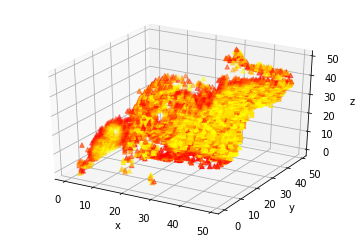

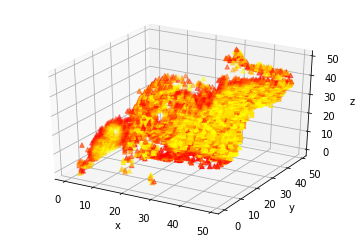

In [66]:
c.plot_3D()

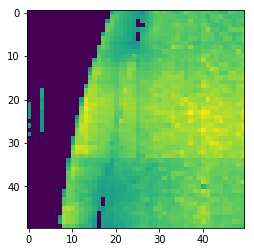

In [76]:
fig, ax = plt.subplots(1,1)
ax.imshow(c.array[15,:,:])

In [69]:
plt.show()

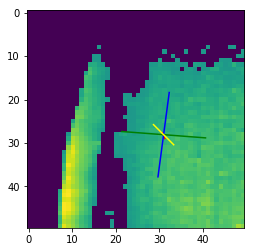

In [106]:
v.plot_PCA_3D()